In [7]:
%pip install tensorflow
%pip install keras
%pip install imblearn
%pip install matplotlib
%pip install seaborn
%pip install scikit-learn
%pip install tensorflow-addons

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### <font color=purple> import libraries </font>

In [8]:
import numpy as np
import random

#   Plotting
import seaborn as sns
import matplotlib.pyplot as plt


#   DataGenerator to read images and rescale images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
import tensorflow_addons as tfa

#   count each class samples
from collections import Counter

#   callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau

#   evaluate precison recall and f1-score of each class of model
from sklearn.metrics import classification_report
#   Show performance of a classification model
from sklearn.metrics import confusion_matrix

#   Different layers
from keras.initializers import GlorotUniform
from keras.models import Sequential
from keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Softmax
from tensorflow.keras.layers import GroupNormalization
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Attention

# split dataset to train, validation and test set
from sklearn.model_selection import train_test_split

#   callbacks
from keras import callbacks

#   SMOTETomek from imblance library
from imblearn.combine import SMOTETomek

#   Optimizer
from tensorflow.keras.optimizers import SGD

from sklearn.metrics import roc_curve, auc
from itertools import cycle


### <font color=purple> Define dataset and rescale images </font> 

In [26]:
## Set Path Here before running the code
WORKING_DIRECTORY =  "C:/Users/rahil/OneDrive/Desktop/Dataset"

##  Name of classes 
CLASSES = ['MildDemented',
           'ModerateDemented',
           'NonDemented',
           'VeryMildDemented']

X, y = [], []

## Images rescaling
datagen = ImageDataGenerator(rescale=1.0/255.0)

#   Load images by resizing and shuffling randomly
train_dataset = datagen.flow_from_directory(WORKING_DIRECTORY, target_size=(176, 208),batch_size=6400, shuffle=True)

### Seperate Dataset from  Data Genrator
X, y = train_dataset.next()

samples_before = len(X)
print("Images shape :\t", X.shape)
print("Labels shape :\t", y.shape)

Found 6400 images belonging to 4 classes.
Images shape :	 (6400, 176, 208, 3)
Labels shape :	 (6400, 4)


### <font color=purple> Define unbalanced testing data </font> 

In [32]:
#   reshaping the images to 1D
X = X.reshape(-1, 176 * 208 * 3)

# create unbalanced dataset and dataset used in rebalancing
X, unbal_x, y, unbal_y = train_test_split(X, y, test_size=0.1)
unbal_x = unbal_x.reshape(-1, 176, 208, 3)

# unbalanced data
unbalanced_samples = len(unbal_x)
print("Number of samples in unbalanced dataset: \t", sorted(Counter(np.argmax(unbal_y, axis = 1)).items()))



Number of samples in unbalanced dataset: 	 [(0, 72), (1, 8), (2, 281), (3, 215)]


### <font color=purple> SMOTETOMEK rebalance the remaining data </font> 

In [33]:
#   Oversampling method to remove imbalance class problem
X, y = SMOTETomek().fit_resample(X, y)

#   reshape images to images size of 208, 176, 3
X = X.reshape(-1, 176, 208, 3)

samples_after = len(X)
print("Number of samples after SMOTETomek :\t", sorted(Counter(np.argmax(y, axis=1)).items()))

Number of samples after SMOTETomek :	 [(0, 2610), (1, 2610), (2, 2610), (3, 2610)]


### <font color=purple> Split balanced dataset for training, validation, and testing </font> 

In [34]:
#   20% split to validation and 80% split to train set
X_train, x_val, y_train, y_val = train_test_split(X,y, test_size = 0.2)

#   20% split to test from 80% of train and 60% remains in train set
X_train, x_test, y_train, y_test = train_test_split(X_train,y_train, test_size = 0.2)

# Number of samples after train test split
print("Number of samples after splitting into Training, validation & test set\n")

print("Train     \t",sorted(Counter(np.argmax(y_train, axis=1)).items()))
print("Validation\t",sorted(Counter(np.argmax(y_val, axis=1)).items()))
print("Test      \t",sorted(Counter(np.argmax(y_test, axis=1)).items()))
print("Unbalanced\t",sorted(Counter(np.argmax(unbal_y, axis=1)).items()))

del X, y

Number of samples after splitting into Training, validation & test set

Train     	 [(0, 1679), (1, 1654), (2, 1699), (3, 1649)]
Validation	 [(0, 518), (1, 566), (2, 484), (3, 520)]
Test      	 [(0, 413), (1, 390), (2, 427), (3, 441)]
Unbalanced	 [(0, 72), (1, 8), (2, 281), (3, 215)]


## **<font color=orange> CNN Model: Convolutional Neural Network implementation for the classification of AD </font>**

### <font color=Orange> Network Architecture </font> 
 

In [35]:
init = GlorotUniform

CNN_model = Sequential()

CNN_model.add(Input(shape=(176, 208, 3)))

CNN_model.add(Convolution2D(16, 1, kernel_initializer=init))
CNN_model.add(GroupNormalization(groups = -1))
CNN_model.add(ReLU())
CNN_model.add(AveragePooling2D(pool_size=(2,2)))

CNN_model.add(Convolution2D(32, 5, kernel_initializer=init))
CNN_model.add(GroupNormalization(groups = -1))
CNN_model.add(ReLU())
CNN_model.add(AveragePooling2D(pool_size=(2,2)))

CNN_model.add(Convolution2D(64, 5, kernel_initializer=init))
CNN_model.add(GroupNormalization(groups = -1))
CNN_model.add(ReLU())
CNN_model.add(AveragePooling2D(pool_size=(2,2)))

CNN_model.add(Convolution2D(128, 5, kernel_initializer=init))
CNN_model.add(GroupNormalization(groups = -1))
CNN_model.add(ReLU())
CNN_model.add(AveragePooling2D(pool_size=(2,2)))

CNN_model.add(Dropout(0.01))

CNN_model.add(Flatten())

CNN_model.add(Dense(256, kernel_initializer=init))
CNN_model.add(ReLU())
CNN_model.add(Dropout(0.03))

CNN_model.add(Dense(4, kernel_initializer=init))
CNN_model.add(Softmax())

CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 176, 208, 16)      64        
                                                                 
 group_normalization_4 (Gro  (None, 176, 208, 16)      32        
 upNormalization)                                                
                                                                 
 re_lu_5 (ReLU)              (None, 176, 208, 16)      0         
                                                                 
 average_pooling2d_4 (Avera  (None, 88, 104, 16)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_5 (Conv2D)           (None, 84, 100, 32)       12832     
                                                                 
 group_normalization_5 (Gro  (None, 84, 100, 32)      

### <font color=Orange> Compile the model </font> 

In [36]:
### Model Compilation
CNN_model.compile(
    optimizer=SGD(learning_rate=0.01), 
    loss = tf.keras.losses.CategoricalCrossentropy(name='loss'), 
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='acc'), 
        tf.keras.metrics.AUC(name='auc'),
        tfa.metrics.F1Score(num_classes=4),
        tf.metrics.Precision(name="precision"),
        tf.metrics.Recall(name="recall") ])

### <font color=Orange> Define learning callback rate </font> 

In [37]:
# callbacks used in model to perform well
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=2)

CALLBACKS = [rop_callback]

### <font color=Orange> Training </font> 

In [38]:
#   declare to run on small gpu create batch sizes of images
valAug = ImageDataGenerator()

#   defining batch size
batch_size = 8

history = CNN_model.fit(valAug.flow(X_train, y_train, batch_size=batch_size, shuffle = True),
steps_per_epoch=len(X_train) // batch_size,
validation_data=valAug.flow(x_val, y_val, batch_size=batch_size, shuffle = True),
validation_steps=len(x_test) // batch_size,
epochs= 12,
batch_size=batch_size,
callbacks = CALLBACKS
)

Epoch 1/12
835/835 [==============================] - 84s 98ms/step - loss: 0.8369 - acc: 0.6041 - auc: 0.8683 - f1_score: 0.5939 - precision: 0.7400 - recall: 0.4514 - val_loss: 0.6023 - val_acc: 0.7236 - val_auc: 0.9328 - val_f1_score: 0.7043 - val_precision: 0.8103 - val_recall: 0.5751 - lr: 0.0100
Epoch 2/12
835/835 [==============================] - 81s 97ms/step - loss: 0.5884 - acc: 0.7273 - auc: 0.9352 - f1_score: 0.7243 - precision: 0.7889 - recall: 0.6498 - val_loss: 0.5688 - val_acc: 0.7344 - val_auc: 0.9390 - val_f1_score: 0.7322 - val_precision: 0.7923 - val_recall: 0.6809 - lr: 0.0100
Epoch 3/12
835/835 [==============================] - 81s 97ms/step - loss: 0.4400 - acc: 0.8023 - auc: 0.9645 - f1_score: 0.8014 - precision: 0.8350 - recall: 0.7674 - val_loss: 0.3025 - val_acc: 0.8804 - val_auc: 0.9849 - val_f1_score: 0.8723 - val_precision: 0.8966 - val_recall: 0.8594 - lr: 0.0100
Epoch 4/12
835/835 [==============================] - 81s 97ms/step - loss: 0.2977 - acc: 0

### <font color=Orange> Evaluation using balanced test data </font> 

In [39]:
### Evaluate Model
test_scores = CNN_model.evaluate(x_test, y_test, batch_size = 32)


print("\n\nTesting Loss : \t\t {0:0.6f}".format(test_scores[0] ))
print("Testing Accuracy : \t {0:0.6f} %".format(test_scores[1] * 100))
print("Testing AUC : \t\t {0:0.6f} %".format(test_scores[2] * 100))
print("Testing F1-Score : \t {0:0.6f} %".format(((test_scores[3][0] + test_scores[3][1] + test_scores[3][2] + test_scores[3][3])/4) * 100))
print("Testing Precision : \t {0:0.6f} %".format(test_scores[4] * 100))
print("Testing Recall : \t {0:0.6f} %".format(test_scores[5] * 100))

53/53 [==============================] - 8s 151ms/step - loss: 0.0493 - acc: 0.9850 - auc: 0.9989 - f1_score: 0.9855 - precision: 0.9850 - recall: 0.9838


Testing Loss : 		 0.049281
Testing Accuracy : 	 98.503888 %
Testing AUC : 		 99.889153 %
Testing F1-Score : 	 98.551488 %
Testing Precision : 	 98.502100 %
Testing Recall : 	 98.384202 %


In [40]:
pred_labels = CNN_model.predict(x_test, batch_size=32)

def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(y_test, pred_labels, target_names=CLASSES))

53/53 [==============================] - 8s 140ms/step
                  precision    recall  f1-score   support

    MildDemented       0.99      1.00      0.99       413
ModerateDemented       1.00      1.00      1.00       390
     NonDemented       0.97      0.98      0.97       427
VeryMildDemented       0.98      0.97      0.97       441

       micro avg       0.99      0.99      0.99      1671
       macro avg       0.99      0.99      0.99      1671
    weighted avg       0.99      0.99      0.99      1671
     samples avg       0.99      0.99      0.99      1671



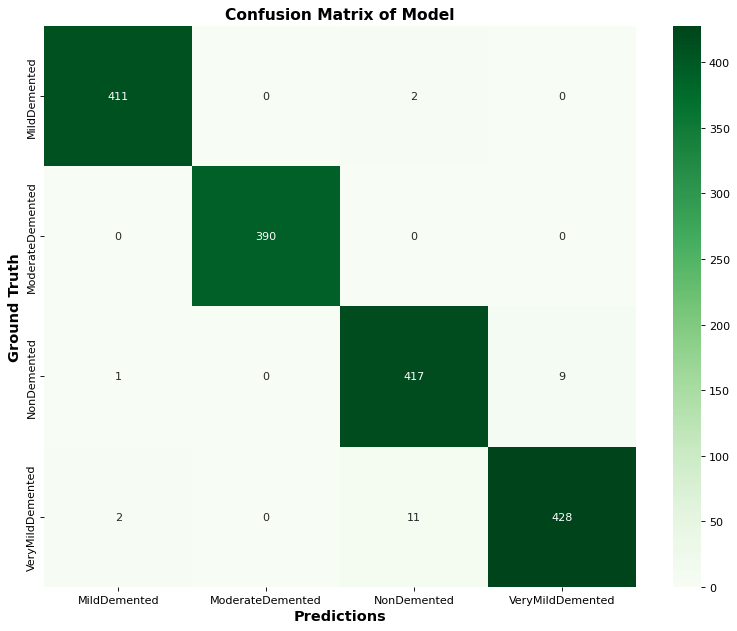

In [41]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(y_test, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES, yticklabels=CLASSES)

plt.title('Confusion Matrix of Model', fontweight='bold', fontsize=14.0)
plt.xlabel('Predictions', fontweight='bold', fontsize=13)
plt.ylabel('Ground Truth', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show(ax)

### <font color=Orange> Evaluation using unbalanced test data </font> 

In [42]:
## evaluation with unbalanced data
unbal_scores = CNN_model.evaluate(unbal_x, unbal_y, batch_size = 32)


print("\n\nTesting Loss : \t\t {0:0.6f}".format(unbal_scores[0] ))
print("Testing Accuracy : \t {0:0.6f} %".format(unbal_scores[1] * 100))
print("Testing AUC : \t\t {0:0.6f} %".format(unbal_scores[2] * 100))
print("Testing F1-Score : \t {0:0.6f} %".format(((unbal_scores[3][0] + unbal_scores[3][1] + unbal_scores[3][2] + unbal_scores[3][3])/4) * 100))
print("Testing Precision : \t {0:0.6f} %".format(unbal_scores[4] * 100))
print("Testing Recall : \t {0:0.6f} %".format(unbal_scores[5] * 100))

18/18 [==============================] - 3s 89ms/step - loss: 0.0985 - acc: 0.9670 - auc: 0.9962 - f1_score: 0.9714 - precision: 0.9686 - recall: 0.9653


Testing Loss : 		 0.098508
Testing Accuracy : 	 96.701390 %
Testing AUC : 		 99.620926 %
Testing F1-Score : 	 97.140324 %
Testing Precision : 	 96.864110 %
Testing Recall : 	 96.527779 %


In [43]:
pred_labels_unbal = CNN_model.predict(unbal_x, batch_size=32)

def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels_unbal in pred_labels_unbal:
    labels_unbal = roundoff(labels_unbal)

print(classification_report(unbal_y, pred_labels_unbal, target_names=CLASSES))

18/18 [==============================] - 3s 144ms/step
                  precision    recall  f1-score   support

    MildDemented       0.96      0.94      0.95        72
ModerateDemented       1.00      1.00      1.00         8
     NonDemented       0.98      0.98      0.98       281
VeryMildDemented       0.95      0.96      0.96       215

       micro avg       0.97      0.97      0.97       576
       macro avg       0.97      0.97      0.97       576
    weighted avg       0.97      0.97      0.97       576
     samples avg       0.97      0.97      0.97       576



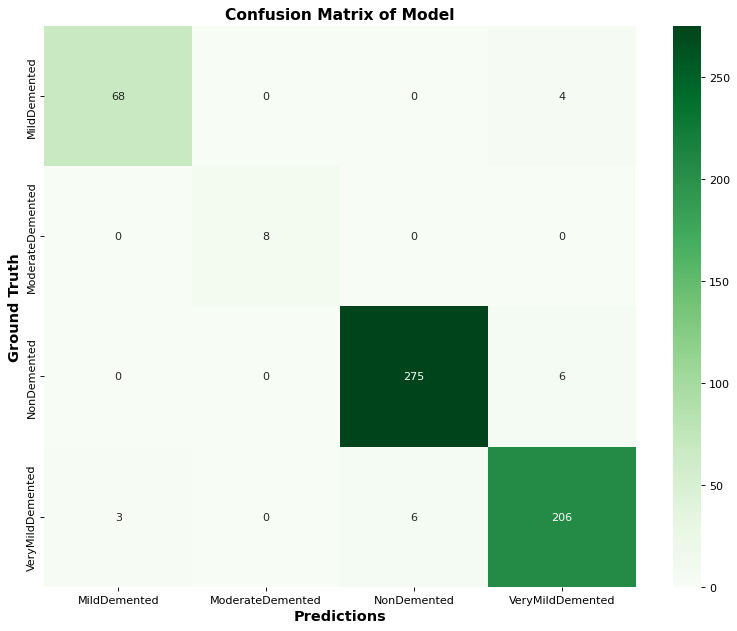

In [44]:
pred_ls_unbal = np.argmax(pred_labels_unbal, axis=1)
test_ls_unbal = np.argmax(unbal_y, axis=1)

conf_arr_unbal = confusion_matrix(test_ls_unbal, pred_ls_unbal)

plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr_unbal, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES, yticklabels=CLASSES)

plt.title('Confusion Matrix of Model', fontweight='bold', fontsize=14.0)
plt.xlabel('Predictions', fontweight='bold', fontsize=13)
plt.ylabel('Ground Truth', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show(ax)